# Image Segmentation

## New Dataset 

Based on Prof. Rangan's suggestion, in this file we explore the possiblity of using Unity to create 3D scenes and use them to create a new segmentation dataset for UNet. 

---


**By**
### Uljad Berdica
### Mohamed Alhossani
### Adam Ali-Hassan

In [ ]:
#basic python
import numpy as np
import matplotlib.pyplot as plt
import os

#to work with images
from google.colab.patches import cv2_imshow
import argparse
import imutils
import cv2
import pathlib
from google.colab import drive
from PIL import Image


#For the WaterShed
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from skimage.transform import resize

## We will import the pyTorch stuff in later cells


In [ ]:
drive.mount('/content/drive',force_remount=True)
img_folder='/content/drive/My Drive/An_IntroToML_CLASS/ClassProject_introML/Img/Adam1/Input'

Mounted at /content/drive


In [ ]:
mlsc4_id = '1oJ_OqP79keKmhfFzDE1tKZUCWd9z1JpU'
mlsc3_id = '1cnrH-Wk0zux-AvWdQjhg_md81AV06hVn'
mlsc2_id = '1QOwNQoUwa8G3hHECUmJY2DfkcGJBK3tz'

mlsc4_download_link = "https://drive.google.com/uc?export=download&id=" + mlsc4_id
mlsc3_download_link = "https://drive.google.com/uc?export=download&id=" + mlsc3_id
mlsc2_download_link = "https://drive.google.com/uc?export=download&id=" + mlsc2_id

!wget -O mlsc4.png --no-check-certificate "$mlsc4_download_link"
!wget -O mlsc3.png --no-check-certificate "$mlsc3_download_link"
!wget -O mlsc2.png --no-check-certificate "$mlsc2_download_link"

--2021-12-18 01:33:35--  https://drive.google.com/uc?export=download&id=1oJ_OqP79keKmhfFzDE1tKZUCWd9z1JpU
Resolving drive.google.com (drive.google.com)... 74.125.132.101, 74.125.132.139, 74.125.132.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.132.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dm1m29ivslnvutecg5vcfim857okl970/1639791150000/02205992142591168137/*/1oJ_OqP79keKmhfFzDE1tKZUCWd9z1JpU?e=download [following]
--2021-12-18 01:33:36--  https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dm1m29ivslnvutecg5vcfim857okl970/1639791150000/02205992142591168137/*/1oJ_OqP79keKmhfFzDE1tKZUCWd9z1JpU?e=download
Resolving doc-0s-70-docs.googleusercontent.com (doc-0s-70-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-0s-70-docs.googleusercontent.com (doc-0s

(860, 1718, 3)
(172, 343, 3)


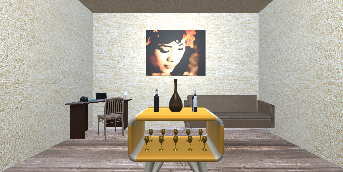

In [ ]:
img1_name="mlsc2.png"
img1=cv2.imread(os.path.join(img_folder,img1_name))
img1=cv2.imread(img1_name)
print(img1.shape)

scale_percent = 20 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)

img1= cv2.resize(img1, dim)
print(img1.shape)
cv2_imshow(img1)

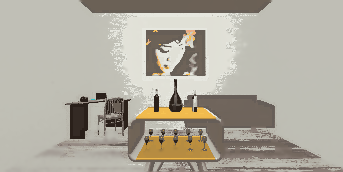

In [ ]:
shifted = cv2.pyrMeanShiftFiltering(img1, 80, 50)
cv2_imshow(shifted)

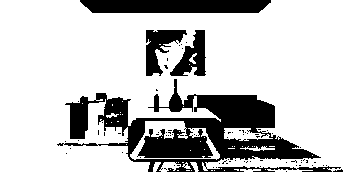

In [ ]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

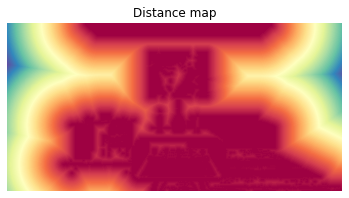

In [ ]:
# For using the watershed algorithm, we need to find peaks of the topographic map.
# fisrt we need to build the distance map by computing the Euclidean Distance to the closest zero (i.e., background pixel) 
# for each of the foreground pixels.  
D = ndimage.distance_transform_edt(thresh)
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(D,cmap="Spectral")
ax.set_title('Distance map')
plt.show()

In [ ]:
# perform a connected component analysis on the local peaks,
# then appy the Watershed algorithm
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("{} unique segments found".format(len(np.unique(labels)) - 1))

10 unique segments found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


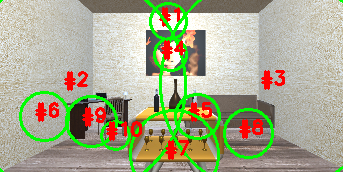

-1

In [ ]:
# then we just need to assign each pixel with different labels found by watershed method
# we will loop each unique labels  
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object which have the same labels 
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(img1, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(img1, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2_imshow(img1)
cv2.waitKey(0)

# Using UNet

In [ ]:
%cd /content
!git clone https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial.git

/content
fatal: destination path 'PyTorch-2D-3D-UNet-Tutorial' already exists and is not an empty directory.


In [ ]:
import sys
import torch 
sys.path.append('/content/PyTorch-2D-3D-UNet-Tutorial')

In [ ]:
from skimage.io import imread
from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

In [ ]:
#Checking if the sizes of the outputs are correct
model = UNet(in_channels=1,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')



Out: torch.Size([1, 2, 512, 512])


In [ ]:
from torchsummary import summary
summary = summary(model.cuda(), (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
         MaxPool2d-7         [-1, 32, 256, 256]               0
         DownBlock-8  [[-1, 32, 256, 256], [-1, 32, 512, 512]]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14    

In [ ]:
#
shape = 1920

def compute_max_depth(shape, max_depth=10, print_out=True):
    shapes = []
    shapes.append(shape)
    for level in range(1, max_depth):
        if shape % 2 ** level == 0 and shape / 2 ** level > 1:
            shapes.append(shape / 2 ** level)
            if print_out:
                print(f'Level {level}: {shape / 2 ** level}')
        else:
            if print_out:
                print(f'Max-level: {level - 1}')
            break

    return shapes


out = compute_max_depth(shape, print_out=True, max_depth=10)

Level 1: 960.0
Level 2: 480.0
Level 3: 240.0
Level 4: 120.0
Level 5: 60.0
Level 6: 30.0
Level 7: 15.0
Max-level: 7


In [ ]:
low = 10
high = 512
depth = 8


def compute_possible_shapes(low, high, depth):
    possible_shapes = {}
    for shape in range(low, high + 1):
        shapes = compute_max_depth(shape,
                                   max_depth=depth,
                                   print_out=False)
        if len(shapes) == depth:
            possible_shapes[shape] = shapes

    return possible_shapes

possible_shapes = compute_possible_shapes(low, high, depth)

print(possible_shapes)

{256: [256, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0], 384: [384, 192.0, 96.0, 48.0, 24.0, 12.0, 6.0, 3.0], 512: [512, 256.0, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0]}


Due to timing constraints we are using a pre trained model and will simply load the weights. No trainer objects will be created.

In [ ]:
'''root = pathlib.Path.cwd() /'Unity'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames'''

# input and target files
images_names = '/content/Unity/Input' #get_filenames_of_path(root / 'Input')
targets_names = '/content/Unity/Target' #get_filenames_of_path(root / 'Target')

# read images and store them in memory
#images = [imread(img_name) for img_name in images_names]
#targets = [imread(tar_name) for tar_name in targets_names]

images = []
targets = []

images.append(imread('mlsc2.png'))
images.append(imread('mlsc3.png'))
#images.append(imread('mlsc4.png'))

targets.append(imread('mlsc2t.png'))
targets.append(imread('mlsc3t.png'))
#targets.append(imread('mlsc4t.png'))

print(images)
print(len(images))

# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

# root directory
root = pathlib.Path.cwd() / 'Carvana'

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model is the same defined before
# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_name = 'carvana_model.pt'
model_weights = torch.load(pathlib.Path.cwd()/'PyTorch-2D-3D-UNet-Tutorial'/ model_name)

model.load_state_dict(model_weights)

[array([[[188, 171, 141, 255],
        [210, 206, 190, 255],
        [235, 245, 249, 255],
        ...,
        [214, 211, 192, 255],
        [214, 209, 191, 255],
        [227, 227, 221, 255]],

       [[224, 225, 219, 255],
        [192, 181, 158, 255],
        [196, 194, 179, 255],
        ...,
        [233, 235, 238, 255],
        [219, 214, 203, 255],
        [204, 195, 171, 255]],

       [[223, 221, 209, 255],
        [248, 255, 255, 255],
        [206, 204, 193, 255],
        ...,
        [199, 187, 158, 255],
        [202, 193, 166, 255],
        [216, 215, 202, 255]],

       ...,

       [[186, 194, 200, 255],
        [190, 201, 211, 255],
        [183, 188, 187, 255],
        ...,
        [120, 106, 101, 255],
        [120, 107, 102, 255],
        [121, 107, 102, 255]],

       [[173, 172, 160, 255],
        [164, 157, 132, 255],
        [166, 162, 140, 255],
        ...,
        [111,  97,  92, 255],
        [113, 100,  95, 255],
        [118, 105, 100, 255]],

       [[16

<All keys matched successfully>

In [ ]:
#pre and pos process functions

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

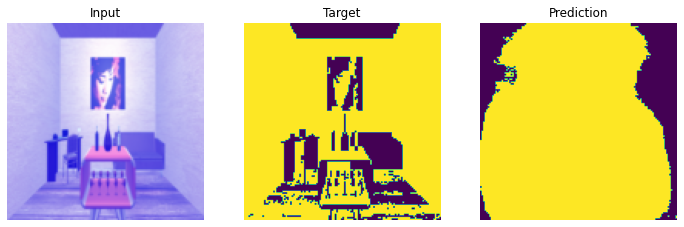

In [ ]:
row=len(images_res)-1
fig=plt.figure(figsize=(12, 12))

for i in range(row):
  fig.add_subplot(row, 3, 3*i+1)
  plt.imshow(images_res[i])
  plt.title("Input")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+2)
  plt.imshow(targets_res[i])
  plt.title("Target")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+3)
  plt.imshow(output[i])
  plt.title("Prediction")
  plt.axis('off')
plt.show()

Trying out other data

In [ ]:
%cd /content
!git clone https://github.com/uljadberdica1000/Segmentation_Exploration.git


print(type(pathlib.Path.cwd()))

In [ ]:
sys.path.append('/content/Segmentation_Exploration')
print(pathlib.Path.cwd())
print(sys.path)

In [ ]:
# sys.path.pop()
# print(sys.path)
print(pathlib.Path.cwd())

In [ ]:
img_folder='/content/drive/My Drive/An_IntroToML_CLASS/ClassProject_introML/Img/segmented_data/segmented_data/train'
print(img_folder)

In [ ]:
for filename in os.listdir(img_folder):

  images_names.append(os.path.join(img_folder,filename))
  targets_names.append(os.path.join(img_folder,filename))

images_names=images_names[:3]
targets_names=targets_names[:3]

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

print(len(images))
# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

# root directory
root = pathlib.Path.cwd() / 'Carvana'

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model is the same defined before
# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_name = 'carvana_model.pt'
model_weights = torch.load(pathlib.Path.cwd()/'PyTorch-2D-3D-UNet-Tutorial'/ model_name)

model.load_state_dict(model_weights)

#pre and pos process functions

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]



row=len(images_res)-1
fig=plt.figure(figsize=(12, 12))

for i in range(row):
  fig.add_subplot(row, 3, 3*i+1)
  plt.imshow(images_res[i])
  plt.title("Input")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+2)
  plt.imshow(targets_res[i])
  plt.title("Target")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+3)
  plt.imshow(output[i])
  plt.title("Prediction")
  plt.axis('off')
plt.show()

In [ ]:
img_folder='/content/drive/My Drive/An_IntroToML_CLASS/ClassProject_introML/Img/Uljad1'

images_names=[]
targets_names=[]
for filename in os.listdir(img_folder):
  images_names.append(os.path.join(img_folder,filename))
  targets_names.append(os.path.join(img_folder,filename))

  print(filename)

images_names=images_names[:3]
targets_names=targets_names[:3]

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

print(len(images))

# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

# root directory
root = pathlib.Path.cwd() / 'Carvana'

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model is the same defined before
# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_name = 'carvana_model.pt'
model_weights = torch.load(pathlib.Path.cwd()/'PyTorch-2D-3D-UNet-Tutorial'/ model_name)

model.load_state_dict(model_weights)

#pre and pos process functions

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]



row=len(images_res)-1
fig=plt.figure(figsize=(12, 12))

for i in range(row):
  fig.add_subplot(row, 3, 3*i+1)
  plt.imshow(images_res[i])
  plt.title("Input")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+2)
  plt.imshow(targets_res[i])
  plt.title("Target")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+3)
  plt.imshow(output[i])
  plt.title("Prediction")
  plt.axis('off')
plt.show()

In [ ]:
img_folder='/content/drive/My Drive/An_IntroToML_CLASS/ClassProject_introML/Img/Adam1'

images_names=[]
targets_names=[]
for filename in os.listdir(img_folder):
  images_names.append(os.path.join(img_folder,filename))
  targets_names.append(os.path.join(img_folder,filename))

  print(filename)

# images_names=images_names[:3]
# targets_names=targets_names[:3]

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

print(len(images))

# Resize images and targets
images_res = [resize(img, (512, 512, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
targets_res = [resize(tar, (512, 512), **resize_kwargs) for tar in targets]

# root directory
root = pathlib.Path.cwd() / 'Carvana'

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model is the same defined before
# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_name = 'carvana_model.pt'
model_weights = torch.load(pathlib.Path.cwd()/'PyTorch-2D-3D-UNet-Tutorial'/ model_name)

model.load_state_dict(model_weights)

#pre and pos process functions

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]



row=len(images_res)
fig=plt.figure(figsize=(12, 12))

for i in range(row):
  fig.add_subplot(row, 3, 3*i+1)
  plt.imshow(images_res[i])
  plt.title("Input")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+3)
  plt.imshow(output[i])
  plt.title("Prediction")
  plt.axis('off')
plt.show()